# Image classificaiton with SVM algorithms

## Problem formulation

The goal of this task is to predict the class of a given image in the CIFAR-10 dataset. This task is treated as a multiclassification problem using machine learnign models.

SVM is selected as the machine learning algorithm to perform this task. SVM is a binary classification learning algorithm. To extend the algorithm for multiclassificaiton, we will implement One-vs-Rest strategy to transform the multi-class problem into binary classification problem and build different binary classifiers. One-vs-Rest classifier models each class against all of the other classes independently.

## Data Loading 

In [1]:
# sklearnex is used for CPU optimizations patching

try:
    from sklearnex import patch_sklearn 
except ImportError:
    !pip install scikit-learn-intelex
    from sklearnex import patch_sklearn

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt

#load data

# Please make sure the path to the dataset is correct before running the script
DATA_PATH = "data/"

# this funciton unpickles data from file 
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# unpickle all data batches
batch1=unpickle(DATA_PATH+"data_batch_1")
batch2=unpickle(DATA_PATH+"data_batch_2")
batch3=unpickle(DATA_PATH+"data_batch_3")
batch4=unpickle(DATA_PATH+"data_batch_4")
batch5=unpickle(DATA_PATH+"data_batch_5")
test_batch=unpickle(DATA_PATH+"test_batch")
meta=unpickle(DATA_PATH+"batches.meta")

# save five data batch into a list
training_data=[batch1,batch2,batch3,batch4,batch5]

# inspect data inside the dictionary 
print(batch1)
print(meta)


{b'batch_label': b'training batch 1 of 5', b'labels': [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1, 2, 2, 9, 2, 6, 6, 1, 9, 5, 0, 4, 7, 6, 7, 1, 8, 1, 1, 2, 8, 1, 3, 3, 6, 2, 4, 9, 9, 5, 4, 3, 6, 7, 4, 6, 8, 5, 5, 4, 3, 1, 8, 4, 7, 6, 0, 9, 5, 1, 3, 8, 2, 7, 5, 3, 4, 1, 5, 7, 0, 4, 7, 5, 5, 1, 0, 9, 6, 9, 0, 8, 7, 8, 8, 2, 5, 2, 3, 5, 0, 6, 1, 9, 3, 6, 9, 1, 3, 9, 6, 6, 7, 1, 0, 9, 5, 8, 5, 2, 9, 0, 8, 8, 0, 6, 9, 1, 1, 6, 3, 7, 6, 6, 0, 6, 6, 1, 7, 1, 5, 8, 3, 6, 6, 8, 6, 8, 4, 6, 6, 1, 3, 8, 3, 4, 1, 7, 1, 3, 8, 5, 1, 1, 4, 0, 9, 3, 7, 4, 9, 9, 2, 4, 9, 9, 1, 0, 5, 9, 0, 8, 2, 1, 2, 0, 5, 6, 3, 2, 7, 8, 8, 6, 0, 7, 9, 4, 5, 6, 4, 2, 1, 1, 2, 1, 5, 9, 9, 0, 8, 4, 1, 1, 6, 3, 

Loaded in this way, each of the batch files contains a dictionary with the following elements:

data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

In [3]:
# checking dataset size 

# print the pixal values for one image and the number of images in each data batch 
for batch in training_data:
  print(batch[b'data'][1].size)
  print(len(batch[b'labels']))


3072
10000
3072
10000
3072
10000
3072
10000
3072
10000


## Reshape images in train and test dataset

50000


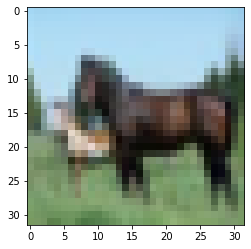

In [4]:
from skimage.transform import resize

images=[]
flat_images=[]
labels=[]

# this funciton reshapes the image data into (32,32,3) array 
def reshape_image(image):
  img_r=image[0:1024].reshape(32,32)
  img_g=image[1024:2048].reshape(32,32)
  img_b=image[2048:].reshape(32,32)
  img = np.dstack((img_r, img_g, img_b))
  return img

# reshape training dataset
for batch in training_data:
  for i in range(0,10000):
    image=batch[b'data'][i, :]
    reshaped_img = reshape_image(image)
    images.append(reshaped_img)
    flat_images.append(reshaped_img.flatten())

# check total number of images  
print(len(images))

# plot the first image 
plt.imshow(images[12],interpolation='nearest')


10000


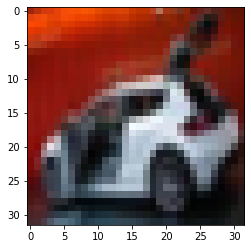

In [5]:
# reshape test dataset 
test_images=[]
flat_test_images=[]
for i in range(0,10000):
    image=test_batch[b'data'][i, :]
    img = reshape_image(image)
    test_images.append(img)
    flat_test_images.append(img.flatten())

print(len(test_images))
plt.imshow(test_images[6],interpolation='nearest')

## SVM with different feature extraction methods


### Goal of SVM:

Increase the distance of decision boundary to classes (or support vectors)
Maximize the number of points that are correctly classified in the training set

### Hyperparameters Tuning:

C - adds penalty for each misclassified data

Gamma - used for non-linear kernel to control the similarity radius. Very large gamma may cause overfit

Kernel selection:

linear is not suitable for this task for being over simplified. Sigmoid kernel is suitable for binary classification. Therefore, we only try Gaussian and polynomial kernel

### Feature extraction methods:
1. Greyscale
2. Histogram of Oriented Gradients (HOG)

## Method 1 - Grey scale pixel values as feature


50000


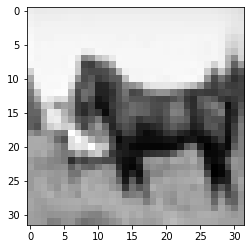

In [6]:
# feature extraction - grey scale 
from sklearn.preprocessing import MinMaxScaler

# initialise lists of features
gray_images=[]
flat_gray_images=[]
rgb_weights = [0.2989, 0.5870, 0.1140]

# training set gray scale
for image in images:
  grayscale= np.dot(image[...,:3],rgb_weights)
  gray_images.append(grayscale)
  flat_gray_images.append(grayscale.flatten())

print(len(flat_gray_images))
plt.imshow(gray_images[12], cmap=plt.get_cmap('gray'))

10000


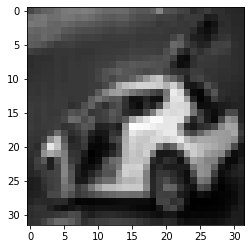

In [7]:
# testing set gray scale
gray_test_images=[]
flat_gray_test_images=[]

for image in test_images:
  grayscale_test= np.dot(image[...,:3],rgb_weights)
  gray_test_images.append(grayscale_test)
  flat_gray_test_images.append(grayscale_test.flatten())

print(len(gray_test_images))
plt.imshow(gray_test_images[6], cmap=plt.get_cmap('gray'))

### Data Normalisation

It is important to normalise data before PCA as PCA calculates the new axis based on the standard deviation of the features.

In [8]:
# normalising the feature vectors 
scaler = MinMaxScaler(feature_range=(0, 1))
# normalising training set 
rescaled_gray_images = scaler.fit_transform(flat_gray_images)
# normalising testing set 
rescaled_testing_images = scaler.transform(flat_gray_test_images)
print(rescaled_gray_images)
print(rescaled_testing_images)

[[0.24006754 0.17642823 0.18834432 ... 0.73940884 0.48622862 0.38818274]
 [0.67162638 0.52391278 0.40499148 ... 0.53597399 0.53961749 0.53820951]
 [1.         0.99215686 0.99215686 ... 0.32423321 0.32540548 0.32932705]
 ...
 [0.55588892 0.55893432 0.56217308 ... 0.1857923  0.1531208  0.10779039]
 [0.81462695 0.80241514 0.79849357 ... 0.72775709 0.74133453 0.74246444]
 [0.90251025 0.93271053 0.92806379 ... 0.69467378 0.64224305 0.63832148]]
[[0.46497277 0.46294865 0.48328166 ... 0.26084412 0.29091772 0.22804594]
 [0.92156863 0.90588235 0.90980392 ... 0.69782743 0.74533336 0.76745478]
 [0.72189258 0.71319759 0.63184789 ... 0.02325134 0.01754136 0.02975317]
 ...
 [0.06334359 0.05942202 0.05473292 ... 0.10344015 0.10712601 0.09636454]
 [0.12675973 0.1018043  0.1294     ... 0.43026146 0.43075092 0.41988042]
 [0.29867967 0.40253123 0.41105718 ... 0.44276349 0.25528906 0.10313306]]


### Feature reduction using PCA

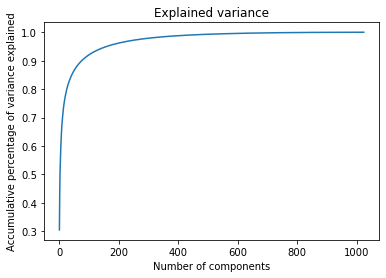

In [9]:
# feature reduction on extracted features using PCA

from sklearn.decomposition import PCA
pca = PCA()
images_pca=pca.fit_transform(rescaled_gray_images)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Accumulative percentage of variance explained')
plt.title('Explained variance')
plt.show()

We can see from the plot that 90% of the variances can be explained by around 80 components 

In [10]:
# fit training and testing data with pca 
pca = PCA(n_components=70)
x_train=pca.fit_transform(rescaled_gray_images)
x_test=pca.transform(rescaled_testing_images)

print("x_train: ")
print(x_train)
print(x_train.size)
print("\n")

print("x_test: ")
print(x_test)
print(x_test.size)
print("\n")

# preparing training and testing labels 
labels=batch1[b'labels'] + batch2[b'labels'] + batch3[b'labels'] + batch4[b'labels'] + batch5[b'labels']
labels=np.array(labels)
y_train=labels
print("y_train: ")
print(y_train)
print(y_train.size)
print("\n")

test_labels=np.array(test_batch[b'labels'])
y_test=test_labels
print("y_test: ")
print(y_test)
print(y_test.size)

x_train: 
[[-2.77069484e+00  1.78090169e+00  1.56025833e+00 ...  2.66288849e-01
  -1.17735392e-02 -1.32869698e-01]
 [ 1.73275291e-01 -6.36854213e-01  3.45023422e+00 ... -3.94558989e-01
   2.05851806e-01  2.59821251e-01]
 [ 4.25159610e+00 -6.85885270e+00 -1.35196675e+00 ... -1.54023814e-01
   3.93831162e-03  5.16861726e-02]
 ...
 [-3.57826747e-01 -6.46550851e+00 -6.26842775e-01 ... -1.77246317e-01
  -3.88416636e-01  1.64214315e-01]
 [ 5.95298875e+00 -1.87105974e+00  3.12382758e+00 ... -1.26575725e-01
   1.53217178e-01 -4.98036704e-02]
 [ 2.23996156e+00 -7.74477697e-01 -2.52858671e+00 ...  1.10942650e-01
   1.59011529e-01 -1.49472848e-01]]
3500000


x_test: 
[[-1.85656492e+00 -2.23956619e-01  7.22492367e-01 ... -4.02809768e-02
  -4.14190179e-01  1.87591310e-01]
 [ 5.27954547e+00 -5.74209316e+00  2.89329547e+00 ... -5.96560979e-02
  -3.40059794e-01  3.05430696e-01]
 [ 2.10309408e+00 -5.21679010e+00  2.20040054e+00 ...  3.57102574e-01
   7.33138376e-02 -1.49939191e-02]
 ...
 [-9.01891712e+

### Stratified k-fold cross validation

In [11]:
# stratified k-fold cross validation with gridsearch 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import time

svc=OneVsRestClassifier(SVC())
parameters={'estimator__C':[1,10],'estimator__gamma':[0.01,0.1],'estimator__kernel':['rbf']}
model=GridSearchCV(svc,param_grid=parameters,cv=4,n_jobs=-1,verbose=2,return_train_score=True)
start_time = time.time()
model.fit(x_train, y_train)
exe_time = time.time()-start_time

print('Best score from grid search:')
print(model.best_score_)
print('Best parameters from grid search:')
print(model.best_params_)
print('Accuracy scores:')
print(model.cv_results_)



Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed: 31.4min remaining: 18.8min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 36.1min finished


Best score from grid search:
0.47864000000000007
Best parameters from grid search:
{'estimator__C': 10, 'estimator__gamma': 0.01, 'estimator__kernel': 'rbf'}
Accuracy scores:
{'mean_fit_time': array([ 585.18839103,  883.65895653, 1239.39915633, 1041.32892519]), 'std_fit_time': array([27.21798469, 40.99194205, 49.63365579,  5.62765436]), 'mean_score_time': array([16.46812689, 37.13686824, 13.19770533, 16.88908309]), 'std_score_time': array([0.34689369, 2.90396816, 1.5077857 , 5.42299029]), 'param_estimator__C': masked_array(data=[1, 1, 10, 10],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_estimator__gamma': masked_array(data=[0.01, 0.1, 0.01, 0.1],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_estimator__kernel': masked_array(data=['rbf', 'rbf', 'rbf', 'rbf'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'

### Model performance 


              precision    recall  f1-score   support

    airplane       0.51      0.52      0.51      1000
  automobile       0.57      0.60      0.58      1000
        bird       0.40      0.32      0.36      1000
         cat       0.38      0.27      0.31      1000
        deer       0.44      0.32      0.37      1000
         dog       0.47      0.45      0.46      1000
        frog       0.48      0.59      0.53      1000
       horse       0.54      0.64      0.58      1000
        ship       0.52      0.65      0.58      1000
       truck       0.54      0.58      0.56      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000

[[516  39  66  13  51  24  44  35 168  44]
 [ 30 603   8  19  16  16  47  31  82 148]
 [ 99  29 322  83  96  85 119  80  56  31]
 [ 63  42  65 266  66 159 141  83  43  72]
 [ 74  28 133  57 320  64 130 110  48  36]
 [ 38  25  67 119  50 445 

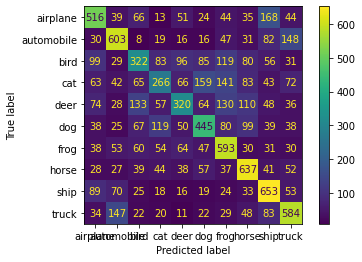



Total training time:
0:41:18


In [12]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
y_pred = model.predict(x_test)
target_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(classification_report(y_test, y_pred, target_names=target_names))

cm=confusion_matrix(y_true=y_test, y_pred=y_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp.plot()
plt.show()

def convert(seconds):
    min, sec = divmod(seconds, 60)
    hour, min = divmod(min, 60)
    return "%d:%02d:%02d" % (hour, min, sec)

print("\n")
print("Total training time:")
print(convert(exe_time))

## Method 2 - Histogram of Oriented Gradients (HOG) as features

HOG feature extraction involves:

- computing the gradient image in x and y

- computing gradient histograms

- normalising across blocks

- flattening into a feature vector. The feature vectors contain only pixel values between 0 and 1 (normalised). 

Hyperparameters:

- orientations: Number of bins in the histogram
- pixels_per_cell: Determines the size of the cell
- cells_per_block: Number of cells per block. The gradient and orientation of each cell is calculated
- visualize: A boolean whether to return the image of the HOG
- feature_vector: A boolean to return the data as a feature vector as a flattened array

https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hog

[0.20499672 0.23344072 0.31945986 ... 0.29870565 0.18105771 0.26926846]


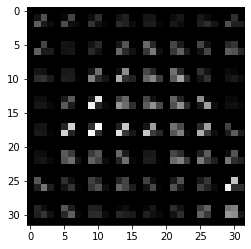

In [13]:
from skimage.feature import hog
hog_images=[]
hog_features=[]
for image in gray_images:
  features, hog_image = hog(image,pixels_per_cell=(4, 4),cells_per_block=(2, 2), feature_vector=True, visualize=True)
  hog_images.append(hog_image)
  hog_features.append(features)

plt.imshow(hog_images[0], cmap="gray")
print(hog_features[0])

In [14]:
hog_images[0].size

1024

[0.23627074 0.08157692 0.09084757 ... 0.         0.         0.        ]


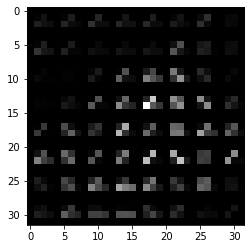

In [22]:
hog_images_test=[]
hog_features_test=[]
for image in gray_test_images:
  features, hog_image = hog(image, pixels_per_cell=(4, 4),cells_per_block=(2, 2), visualize=True)
  hog_images_test.append(hog_image)
  hog_features_test.append(features)

plt.imshow(hog_images_test[6], cmap="gray")
print(hog_features_test[6])


### Feature reduction with PCA

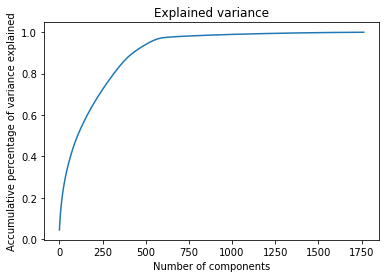

In [23]:
pca = PCA()
images_pca=pca.fit_transform(hog_features)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Accumulative percentage of variance explained')
plt.title('Explained variance')
plt.show()

In [24]:
# fit training and testing data with pca 
pca2 = PCA(n_components=500)
x_train2=pca2.fit_transform(hog_features)
x_test2=pca2.transform(hog_features_test)

print("x_train2: ")
print(x_train2)
print(x_train2.size)
print("\n")

print("x_test2: ")
print(x_test2)
print(x_test2.size)
print("\n")

# preparing training and testing labels 
y_train2=y_train
print("y_train2: ")
print(y_train2)
print(y_train2.size)
print("\n")

y_test2=y_test
print("y_test2: ")
print(y_test2)
print(y_test2.size)

x_train2: 
[[-0.27865751  0.28524596  0.1364709  ...  0.01992809 -0.02674927
   0.06563044]
 [-0.02701405  0.06383311 -0.56006312 ... -0.03411903 -0.11786323
   0.02405368]
 [ 0.65477495 -0.36441293 -0.68957165 ... -0.0406292   0.07906188
  -0.06928952]
 ...
 [ 0.83790244  0.03785215  0.00981084 ...  0.08085924 -0.10371471
   0.09276405]
 [ 1.96694179  0.03417946  1.15305081 ...  0.05293326  0.02631616
  -0.13000793]
 [ 1.37605868 -0.42065914  0.54218402 ...  0.00253449 -0.07540934
   0.00223254]]
25000000


x_test2: 
[[-1.07733007e+00  3.09083752e-01 -1.99386982e-01 ...  1.20043920e-02
   1.46059027e-02  1.02933275e-01]
 [ 1.81874907e+00  5.39381898e-01 -5.83589530e-01 ... -3.07629454e-02
  -1.05544842e-01  1.13357386e-01]
 [ 1.00873260e+00  1.23124269e+00 -3.54425139e-01 ...  1.06487692e-01
   9.07734235e-02  6.83832691e-02]
 ...
 [-1.88135167e+00  4.80901922e-01  8.43324900e-01 ...  1.36003622e-01
  -1.15152694e-01 -7.85059449e-02]
 [ 4.74597938e-01  2.29171218e-01 -6.63955452e-01 .

In [21]:
# stratified k-fold cross validation with gridsearch
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import time

svc=OneVsRestClassifier(SVC())
parameters={'estimator__C':[1],'estimator__gamma':[0.01],'estimator__kernel':['rbf']}
model2=GridSearchCV(svc,param_grid=parameters,cv=4,n_jobs=-1,verbose=2,return_train_score=True)
start_time2 = time.time()
model2.fit(x_train2, y_train2)
exe_time2 = time.time()-start_time2

print('Best score from grid search:')
print(model2.best_score_)
print('Best parameters from grid search:')
print(model2.best_params_)
print('Accuracy scores:')
print(model2.cv_results_)



Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 13.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 13.2min finished


Best score from grid search:
0.55248
Best parameters from grid search:
{'estimator__C': 1, 'estimator__gamma': 0.01, 'estimator__kernel': 'rbf'}
Accuracy scores:
{'mean_fit_time': array([596.30679685]), 'std_fit_time': array([4.89609902]), 'mean_score_time': array([48.62277687]), 'std_score_time': array([0.70375977]), 'param_estimator__C': masked_array(data=[1],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_estimator__gamma': masked_array(data=[0.01],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_estimator__kernel': masked_array(data=['rbf'],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'estimator__C': 1, 'estimator__gamma': 0.01, 'estimator__kernel': 'rbf'}], 'split0_test_score': array([0.54712]), 'split1_test_score': array([0.54816]), 'split2_test_score': array([0.56144]), 'split3_test_score': array([0.5532]), 'mean_test_score': array([0.55248]), 'std_test_score': a

              precision    recall  f1-score   support

    airplane       0.57      0.66      0.61      1000
  automobile       0.67      0.74      0.70      1000
        bird       0.56      0.41      0.47      1000
         cat       0.46      0.25      0.33      1000
        deer       0.53      0.36      0.43      1000
         dog       0.51      0.39      0.44      1000
        frog       0.51      0.77      0.62      1000
       horse       0.54      0.68      0.60      1000
        ship       0.59      0.63      0.61      1000
       truck       0.60      0.72      0.66      1000

    accuracy                           0.56     10000
   macro avg       0.56      0.56      0.55     10000
weighted avg       0.56      0.56      0.55     10000

[[662  36  34  12  27  12  27  25 130  35]
 [ 32 743   9  16  15   6  34   6  56  83]
 [111  23 410  41  67  63 133  62  61  29]
 [ 72  40  53 253  67 141 168  91  33  82]
 [ 52  25  44  38 358  36 206 147  47  47]
 [ 29  17  81  86  44 388 

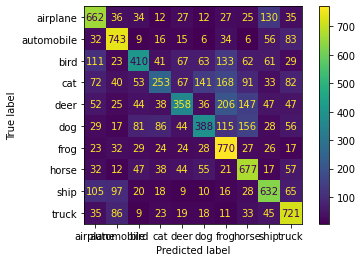

Total training time:
0:18:16


In [25]:
y_pred2 = model2.predict(x_test2)
print(classification_report(y_test2, y_pred2, target_names=target_names))
cm2=confusion_matrix(y_true=y_test2, y_pred=y_pred2)
print(cm2)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2,display_labels=target_names)
disp2.plot()
plt.show()

print("Total training time:")
print(convert(exe_time2))